<a href="https://colab.research.google.com/github/ar819/Masters-Proj-Notebook/blob/main/SegCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SegDiff Notebook FYP
This notebook implements SegCLIP, a mask generation algorithm for use in image inpainting.

Also compares DiffEdit, SegAnything and CLIPSeg mask generation with stable diffusion for inpainting.

Ensure that you select the highest RAM GPU availiable if running all models.

## Setup

### Install Dependencies

In [ ]:
def install_dependencies():
    !pip install --upgrade opencv-python
    !pip install -qq numpy
    !pip install -qq matplotlib
    !pip install -qq fastai
    !pip install -qq accelerate
    !pip install -qq --upgrade transformers diffusers ftfy

# Uncomment this line if you'd like to install the dependencies.
install_dependencies()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00


### Imports and Setup

Mounted at /content/drive


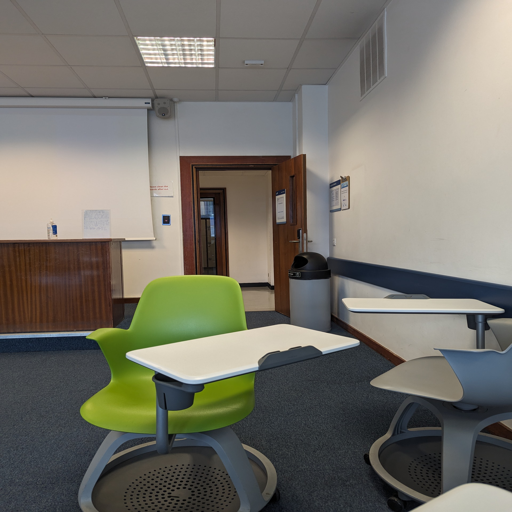

In [ ]:
import os
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from fastai.basics import show_image,show_images
from fastdownload import FastDownload
from pathlib import Path

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel,CLIPTokenizer
from transformers import logging
from transformers import CLIPProcessor, CLIPModel
from diffusers import AutoencoderKL,UNet2DConditionModel,LMSDiscreteScheduler,StableDiffusionInpaintPipeline
from transformers import SamModel, SamProcessor
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from diffusers import DPMSolverMultistepScheduler
import cv2
from diffusers import RePaintPipeline, RePaintScheduler
from transformers import pipeline
import glob
from google.colab import drive
from ipywidgets import interact,FloatSlider
from google.colab.patches import cv2_imshow
from PIL import ImageFilter

# Set device
torch_device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"

# summarize tensor
_s = lambda x: (x.shape,x.max(),x.min())

# mount drive
drive.mount('/content/drive')
# load your own dataset here
images_path = sorted(glob.glob('/content/drive/MyDrive/SouthKenDataset/Demo/*'))
# example image
Image.open(images_path[0]).resize((512,512))

# Display all images



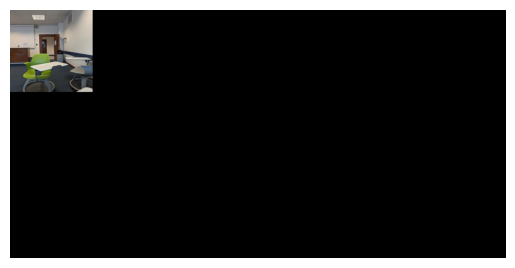

In [ ]:
ims = []
for p in images_path:
  ims.append(Image.open(p).resize((512,512)))
def display_image_grid(image_list, rows, cols):
    # Create a blank canvas for the grid
    canvas = np.zeros((rows * image_list[0].height, cols * image_list[0].width, 3), dtype=np.uint8)

    # Iterate over the images and place them in the canvas
    for i, img in enumerate(image_list):
        row = i // cols
        col = i % cols
        canvas[row * img.height: (row + 1) * img.height, col * img.width: (col + 1) * img.width, :] = np.array(img)

    # Display the image grid
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()
display_image_grid(ims,3,6)


## Authenticate with Hugging Face to access inpainting models

In [ ]:
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

## Load Pretrained Hugging Face Models

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# # Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# # The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
# hyper parameters match those used during training the model
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


# Segment anything model
s_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(torch_device)
s_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

generator = pipeline("mask-generation", model="facebook/sam-vit-huge",device=torch_device)

c_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(torch_device)
c_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



# #CLIPSEG
clipprocessor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipmodel = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(torch_device)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);
vae_magic = 0.18215 # vae model trained with a scale term to get closer to unit variance

# Load RunwayML's Inpainting Model
inpaint = StableDiffusionInpaintPipeline.from_pretrained('runwayml/stable-diffusion-inpainting',revision="fp16",torch_dtype=torch.float16 ).to(torch_device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.mlp.fc1.weight', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.20.layer_norm1.weight', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.bias', 'vision_model.encoder.layers.13.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.self_attn.out_proj.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.layer_norm1.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.18.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_mode

unet/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


# DiffEdit implementation

In [ ]:
def image2latent(im):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(torch_device)*2-1);
    latent = latent.latent_dist.sample() * vae_magic
    return latent

def latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0,1)
    imgs = imgs.detach().cpu().permute(0,2,3,1).numpy()
    imgs = (imgs * 255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

def get_embedding_for_prompt(prompt):
    max_length = tokenizer.model_max_length
    tokens = tokenizer([prompt],padding="max_length",max_length=max_length,truncation=True,return_tensors="pt")
    with torch.no_grad():
        embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
    return embeddings

In [ ]:
# Given a starting image latent and a prompt; predict the noise that should be removed to transform
# the noised source image to a denoised image guided by the prompt.
def predict_noise(text_embeddings,im_latents,seed=torch.seed(),guidance_scale=7,strength=0.5,**kwargs):
    num_inference_steps = 50            # Number of denoising steps

    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise

    uncond = get_embedding_for_prompt('')
    text_embeddings = torch.cat([uncond, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    offset = scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)

    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps] * 1 * 1, device=torch_device)

    start_step = init_timestep
    noise = torch.randn_like(im_latents)
    latents = scheduler.add_noise(im_latents,noise,timesteps=timesteps)
    latents = latents.to(torch_device).float()

    t_start = max(num_inference_steps - init_timestep + offset, 0)
    timesteps = scheduler.timesteps[t_start:].to(torch_device)

    noisy_latent = latents.clone()

    noise_pred = None
    for i, tm in enumerate(timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, tm)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, tm, encoder_hidden_states=text_embeddings)["sample"]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        u = noise_pred_uncond
        g = guidance_scale
        t = noise_pred_text

        # perform guidance
        noise_pred = u + g * (t - u)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, tm, latents).prev_sample

    return latents2images(latents)[0],noise_pred

In [ ]:
# Composite the mask over the provided image; for demonstration purposes
def get_blended_mask(im,mask_gray): # Both expected to be PIL images
    mask_rgb = mask_gray.convert('RGB')
    return Image.blend(im,mask_rgb,0.40)

# Show the original image, the original image with mask and the resulting inpainted image
def demo_diffedit(im_path,p1,p2,**kwargs):
    im_path = Path(im_path)
    out = []

    im = Image.open(im_path).resize((512,512))
    im_latent = image2latent(im)
    out.append(im)

    if 'seed' not in kwargs: kwargs['seed'] = torch.seed()
    mask = calc_diffedit_mask(im_latent,p1,p2,**kwargs)
    # out.append(get_blended_mask(im,mask))
    # out.append(inpaint(prompt=p2,image=im,mask_image=mask,
    #     generator=torch.Generator(torch_device).manual_seed(kwargs['seed'])).images[0])
    # show_images(out)
    return mask

In [ ]:
# For a given reference prompt and a query prompt;
# Run the diffusion process 10 times; Calculating a "noise distance" for each sample
def calc_diffedit_samples(encoded,prompt1,prompt2,n=10,**kwargs):
    diffs=[]
    # So we can reproduce mask generation we generate a list of n seeds
    torch.manual_seed(torch.seed() if 'seed' not in kwargs else kwargs['seed'])
    seeds = torch.randint(0,2**62,(n,)).tolist()
    for i in range(n):
        kwargs['seed'] = seeds[i] # Important to use same seed for the two noise samples
        emb1 = get_embedding_for_prompt(prompt1)
        _im1,n1 = predict_noise(emb1,encoded,**kwargs)
        emb2 = get_embedding_for_prompt(prompt2)
        _im2,n2 = predict_noise(emb2,encoded,**kwargs)

        # Aggregate the channel components by taking the euclidean distance.
        diffs.append((n1-n2)[0].pow(2).sum(dim=0).pow(0.5)[None])
    all_masks = torch.cat(diffs)
    return all_masks

# Given an image latent and two prompts; generate a grayscale diff by sampling the noise predictions
# between the prompts.
def calc_diffedit_diff(im_latent,p1,p2,**kwargs):
    m = calc_diffedit_samples(im_latent,p1,p2,**kwargs)
    m = m.mean(axis=0) # average samples together
    m = (m-m.min())/(m.max()-m.min()) # rescale to interval [0,1]
    m = (m*255.).cpu().numpy().astype(np.uint8)
    m = Image.fromarray(m)
    return m

# Try to improve the mask thru convolutions etc
# assume m is a PIL object containing a grayscale 'diff'
def process_diffedit_mask(m,threshold=0.35,**kwargs):
    m = np.array(m).astype(np.float32)
    m = cv2.GaussianBlur(m,(5,5),1)
    m = (m>(255.*threshold)).astype(np.float32)*255
    m = Image.fromarray(m.astype(np.uint8))
    return m

# Given an image latent and two prompts; generate a binarized mask (PIL) appropriate for inpainting
def calc_diffedit_mask(im_latent,p1,p2,**kwargs):
    m = calc_diffedit_diff(im_latent,p1,p2,**kwargs)
    m = process_diffedit_mask(m,**kwargs)
    m = m.resize((512,512))
    return m

# CLIPSeg


In [ ]:
def ClipSeg(im_path,p1,p2,**kwargs):
  im = Image.open(im_path).resize((512,512));im
  inputs = clipprocessor(text=p1, images=im, padding="max_length", return_tensors="pt").to(torch_device)

  with torch.no_grad():
    outputs = clipmodel(**inputs)
  mask = process_diffedit_mask(torch.sigmoid(outputs.logits).cpu().detach().numpy()*255,threshold=0.07)
  mask = mask.resize((512,512))
  return mask

## Utility functions for SegAnything

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gc

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()
def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

# SegCLIP implementation (Algorithm of interest)

In [ ]:
def square_crop_mask(mask,im):
 # Find contours in the mask
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if len(contours) == 0:
      return Image.fromarray(cv2.bitwise_and(im,im, mask = mask.astype(np.uint8)))

  # Find the bounding box of the largest contour
  largest_contour = max(contours, key=cv2.contourArea)
  x, y, w, h = cv2.boundingRect(largest_contour)

  # Crop the image based on the bounding box
  cropped_image = im[y:y+h, x:x+w]
  cropped_mask = mask[y:y+h, x:x+w]

  return Image.fromarray(cv2.bitwise_and(cropped_image,cropped_image, mask = cropped_mask.astype(np.uint8)))
def segEvery(im): # Segments all objects in input images and returns masks and masked images
  with torch.no_grad():
    outputs = generator(im, points_per_batch=64) # Seganything pipeline
  masks = outputs["masks"]
  show_masks_on_image(im,masks)
  arr_im = np.array(im)
  outs = []
  for m in masks:
    cropped_masked = square_crop_mask(np.array(m,dtype=np.uint8),arr_im)
    outs.append(cropped_masked)
  return outs, masks

def segCLIP(im, segmented_images, masks, p1,b=10):
  # Using segmented images, choose the one that best describes the input prompt
  inputs = c_processor(text=[p1,''], images=segmented_images, return_tensors="pt", padding=True).to(torch_device)
  with torch.no_grad():
    outputs = c_model(**inputs) # CLIP MODEL
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)
    probs = probs.cpu().detach().numpy()
    idx= np.argmax(probs.T[0])
  m = masks[idx]
  m = np.array(m).astype(np.float32)*255
  b= b*2 + 1
  m = cv2.GaussianBlur(m,(b,b),1)
  m = (m>(255.*0.001)).astype(np.float32)*255
  m = Image.fromarray(m.astype(np.uint8))
  return m




# Segment Anything implementation

In [ ]:
def segany(im,input_point):
  ## Region of interest used as input to SegAnything segmentor
  input_points = [input_point]
  inputs = s_processor(im, input_points = input_points, return_tensors="pt").to(torch_device)

  # pop the pixel_values as they are not neded
  # inputs.pop("pixel_values", None)
  # inputs.update({"image_embeddings": image_embeddings})

  with torch.no_grad():
      outputs = s_model(**inputs)

  masks = s_processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
  scores = outputs.iou_scores
  binarized_masks = masks[0].squeeze()
  masks = binarized_masks.cpu().detach()
  mask = masks[2]
  h, w = mask.shape[-2:]
  mask = mask.reshape(h, w).numpy()*255
  mask = Image.fromarray(mask.astype(np.uint8))
  return mask

# SegEdit (not tested)

In [ ]:
def demo_segEdit(im_path,p1,p2,**kwargs):
  im_path = Path(im_path)
  out = []

  im = Image.open(im_path).resize((512,512))
  im_latent = image2latent(im)


  ## DiffEdit used to approximate region of interest
  m = calc_diffedit_diff(im_latent,p1,p2,seed=seed,n=kwargs['n'] if 'n' in kwargs else 5)
  # input_points = []
  # w,h = m.size
  # w1,h2 = im.size
  # for i in range(w):
  #   for j in range(h):
  #     if m.getpixel((i,j))>128:
  #       input_points.append([int(i*w1/w),int(j*h2/h)])
  # plt.scatter(*zip(*input_points))
  # plt.imshow(im)

  ## Region of interest used as input to SegAnything segmentor
  print(len(input_points))
  input_masks = [m]
  inputs = s_processor(im, input_masks = input_masks, return_tensors="pt").to(torch_device)

  # pop the pixel_values as they are not neded
  # inputs.pop("pixel_values", None)
  # inputs.update({"image_embeddings": image_embeddings})

  with torch.no_grad():
      outputs = s_model(**inputs)

  masks = s_processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
  scores = outputs.iou_scores
  binarized_masks = masks[0].squeeze()
  masks = binarized_masks.cpu().detach()
  for m in masks:
    out.append(m)
  mask = masks[2]
  h, w = mask.shape[-2:]
  mask = mask.reshape(h, w).numpy()*255
  mask = Image.fromarray(mask.astype(np.uint8))
  mask = process_diffedit_mask(mask)

  #out.append(get_blended_mask(im,mask))
  #out.append(inpaint(prompt=[p2],image=im,mask_image=mask,
  #generator=torch.Generator(torch_device).manual_seed(kwargs['seed'])).images[0])
  show_images(out)
  return mask


## Demonstrate Mask Generation with SegClip and other methods.

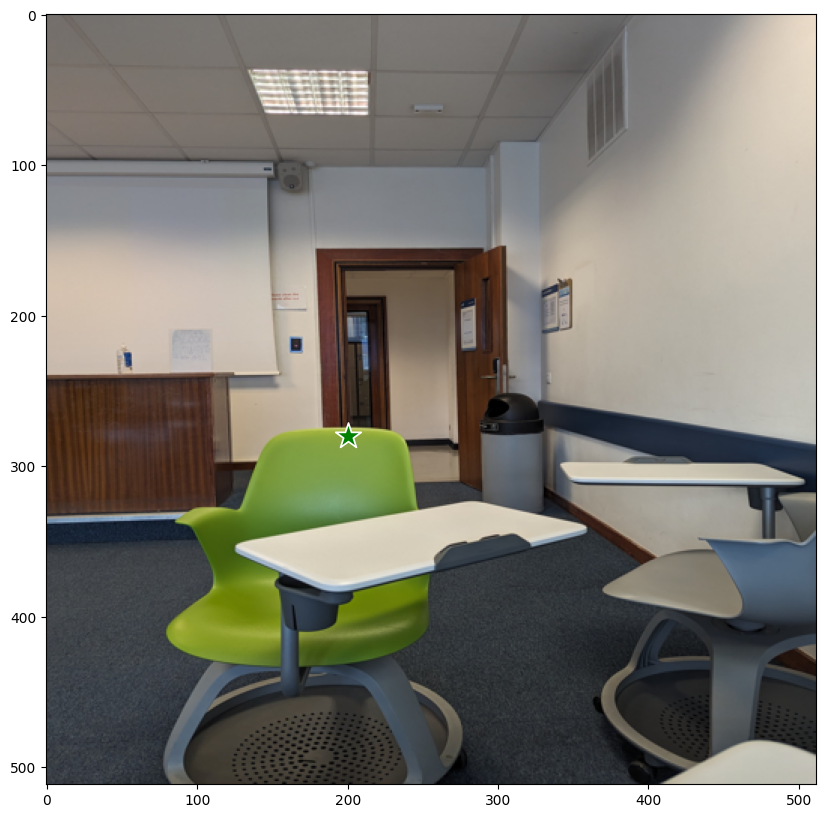

In [ ]:
p= images_path[0]
im = Image.open(p).resize((512,512));im
input_points=[[200,280]]
show_points_on_image(im,input_points)

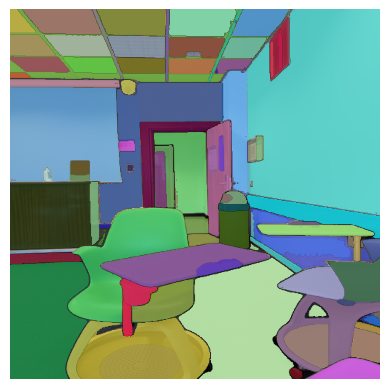

segCLIP time: 10.274287294000032, segany time: 0.5108292849999998     ClipSeg time: 0.1729260439999507, diffedittime: 41.764766966000025.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

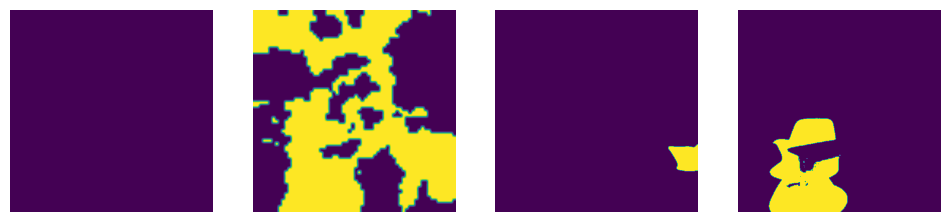

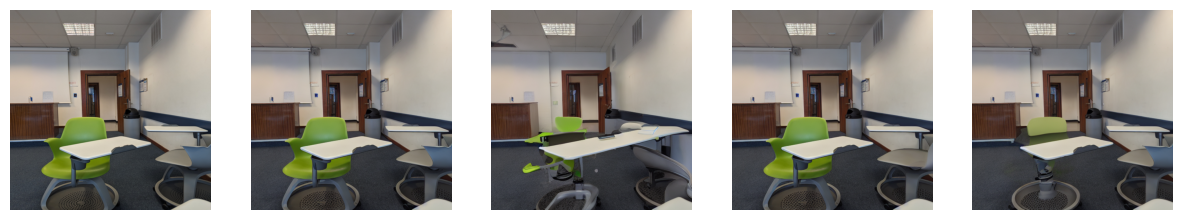

In [ ]:
seed = torch.seed()
seed = 12765083811071779586
folder_name = "./demo"
p1 = "water bottle"
diffedit_p2 = "carpet"
p2 = ''
try:
  os.mkdir(folder_name)
except:
  pass
start = timer()
ims, masks = segEvery(im)
mask3 = segCLIP(im,ims, masks,p1,b=70)
mask3.save(folder_name+"/mask3.jpg")
segCLIPtime = timer()
mask4 = segany(im,input_points)
mask4.save(folder_name+"/mask4.jpg")
seganytime = timer()
mask = ClipSeg(p,p1,p2,seed=seed)
mask.save(folder_name+"/mask.jpg")
clipSegtime= timer()
mask2 = demo_diffedit(p,p1,diffedit_p2,seed=seed)
diffedittime= timer()
print(f"segCLIP time: {segCLIPtime-start}, segany time: {seganytime-segCLIPtime} \
    ClipSeg time: {clipSegtime-seganytime}, diffedittime: {diffedittime-clipSegtime}.")
out = [im]
masks_out = [mask,mask2,mask3,mask4]
out.append(inpaint(prompt=p2,image=im,mask_image=mask,
              generator=torch.Generator(torch_device).manual_seed(seed)).images[0])
out.append(inpaint(prompt=p2,image=im,mask_image=mask2,
              generator=torch.Generator(torch_device).manual_seed(seed)).images[0])
out.append(inpaint(prompt=p2,image=im,mask_image=mask3,
              generator=torch.Generator(torch_device).manual_seed(seed)).images[0])
out.append(inpaint(prompt=p2,image=im,mask_image=mask4,
              generator=torch.Generator(torch_device).manual_seed(seed)).images[0])

show_images(masks_out)
show_images(out)
out[0].save(folder_name+'/original.jpg')
out[1].save(folder_name+'/out1.jpg')
out[2].save(folder_name+'/out2.jpg')
out[3].save(folder_name+'/out3.jpg')
out[4].save(folder_name+'/out4.jpg')


In [ ]:
!zip -r ./tree2.zip ./tree2/

  adding: tree2/ (stored 0%)
  adding: tree2/out1.jpg (deflated 1%)
  adding: tree2/mask4.jpg (deflated 58%)
  adding: tree2/mask.jpg (deflated 56%)
  adding: tree2/out4.jpg (deflated 1%)
  adding: tree2/out3.jpg (deflated 1%)
  adding: tree2/original.jpg (deflated 1%)
  adding: tree2/mask3.jpg (deflated 59%)
  adding: tree2/out2.jpg (deflated 1%)
